In [1]:
'''

GDrive link for video :- https://drive.google.com/drive/folders/11Vxcn1Xj513ZsZeTMwj-gT777CxKbkrG?usp=sharing

'''

'\n\nGDrive link for video :-\n\n'

In [ ]:
'''
All ChatGPT Prompts are written with ##
'''

In [1]:
#Question 1
#Testing if the pre-trained model will work in my environment
#Importing the necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

In [3]:
cudnn.benchmark = True #Used to select the fastest Algorithm wrt Hardware and input size
plt.ion() #Enables interactive mode

In [4]:
#Transforming the images
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), #Randomly crops a region from image and then resizes it into 224x224
        transforms.RandomHorizontalFlip(), #Randomly flips the image horizontally
        transforms.ToTensor(),#Converting to PyTorch Tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #Normalizing
    ]),
    'val': transforms.Compose([
        transforms.Resize(256), #Resizing the image to 256x256
        transforms.CenterCrop(224),#Crops a region of 224x224 from the center of the image
        transforms.ToTensor(),#Converting into PyTorch Tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #Normalizing the data
    ]),
}

data_dir = '/content/drive/MyDrive/EE_353_Data/Assignment 3/hymenoptera_data' #Getting the data from the respective directory

#Creating a dictionary and storing the images
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

#Creating a dictionary and loading the images
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}


dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes #Getting the class names

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #Selects GPU for computation if available

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


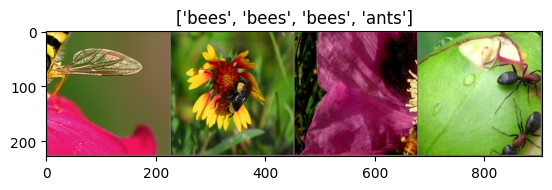

In [5]:
#Defining function to display images
def imshow(inp, title=None):
    """Display image for Tensor."""

    inp = inp.numpy().transpose((1, 2, 0)) #Convert PyTorch Tensor to Numpy array and then Transpose the same
    mean = np.array([0.485, 0.456, 0.406]) #Taking ImageNet mean
    std = np.array([0.229, 0.224, 0.225]) #Taking ImageNet standard deviation
    inp = std * inp + mean #Undoes normalization

    inp = np.clip(inp, 0, 1) #Clipping the values to be in range of (0,1)

    plt.imshow(inp) #Viewing the image

  #Setting title for the plot
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes]) #Displaying images

In [6]:
#Defining a function to train a PyTorch model for a specified number of epochs
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time() #Records starting time

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path) #Saving the model
        best_acc = 0.0

        #Iterates over the number of epochs
        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode
                #Initializing the variables
                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]#Calculating loss of the given epoch
                epoch_acc = running_corrects.double() / dataset_sizes[phase] #Calculating the accuracy of the given epoch

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since #Calculating the time elapsed
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [7]:
#Defining function to visualize predictions made by the model

def visualize_model(model, num_images=6):
    was_training = model.training #Get the current training mode
    model.eval()#Sets to evauation mode

    images_so_far = 0 #Initializng variable to keep track of images so far
    fig = plt.figure() #Used to create a Matplplotlib figure for plotting images

    with torch.no_grad():#Ensures that no gradients are calculated during the visualization
        #Iterating through the data
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device) #Moves input to device
            labels = labels.to(device) #Moves labels to device

            outputs = model(inputs) #Gets predictions from the input
            _, preds = torch.max(outputs, 1)
            #Iterates over each image in the current batch
            for j in range(inputs.size()[0]):
                images_so_far += 1
                #Creating a sub-plot for current image within a grid layout
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')#Sets title for the sub-plot
                imshow(inputs.cpu().data[j])
                #Checks if the specified number of images have been visualized
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
#Prompt given to GPT. :-
'''I need you to help me with step 1:
   The following is the code that is being used :
   { I gave the code till the above block }
   Now I need to get the code to train the above model.
   The issue is that I have skipped the last block of code for the same :
   {I gave the code for fine tuning given in the website }
   as it was given in the question to skip the fine tuning part of the code,
   but now I do not have the code to train the model and to make predictions with it.
   I need you to complete the given code so that I can train the model
'''

# Load pre-trained ResNet18 model
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features

# Freeze all convolutional layers
for param in model_ft.parameters():
    param.requires_grad = False

# Replace the fully connected layer to match the number of classes
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

# Move model to the appropriate device
model_ft = model_ft.to(device)

# Define the loss function and optimizer (only for the new fc layer)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.fc.parameters(), lr=0.001, momentum=0.9)

# Set up learning rate scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Train the model using the existing train_model function
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 97.9MB/s]


Epoch 0/24
----------
train Loss: 0.5944 Acc: 0.6762
val Loss: 0.2422 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.4109 Acc: 0.8197
val Loss: 0.5991 Acc: 0.7516

Epoch 2/24
----------
train Loss: 0.7300 Acc: 0.7008
val Loss: 0.1761 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.4100 Acc: 0.8484
val Loss: 0.1853 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.3578 Acc: 0.8607
val Loss: 0.1807 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.4870 Acc: 0.7623
val Loss: 0.1630 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.3498 Acc: 0.8361
val Loss: 0.2091 Acc: 0.9150

Epoch 7/24
----------
train Loss: 0.3494 Acc: 0.8607
val Loss: 0.1940 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3389 Acc: 0.8320
val Loss: 0.1843 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.4403 Acc: 0.7910
val Loss: 0.2106 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.3762 Acc: 0.8402
val Loss: 0.2029 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3062 Acc: 0.8443
val Loss: 0.2086 Acc: 0.9216

Ep

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


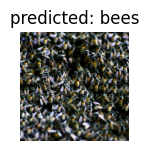

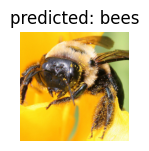

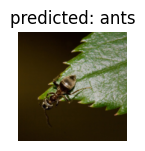

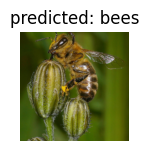

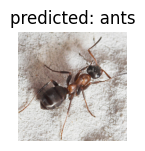

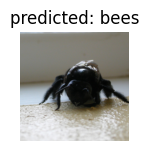

In [9]:
# Visualize predictions
visualize_model(model_ft)

# Question 11

In [10]:
#Importing the necessary Libraries
import torch
from torchvision import models, transforms
from PIL import Image
import os

In [11]:
# Load the pre-trained ResNet18 model and set it to feature extraction mode
model = models.resnet18(weights='IMAGENET1K_V1')
model.eval()  # Set the model to evaluation mode
model.fc = torch.nn.Identity()  # Remove final fully connected layer

In [12]:
# Define the transformation pipeline
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [13]:
#ChatGPT Prompt ==> Generate to me a function to extracts features from images in a given folder
#Defining a function for extracting the features from images in a given folder

def extract_features_from_folder(folder_path):
    """
    Extracts ResNet18 features for all images in the given folder and subfolders.

    Args:
        folder_path (str): Path to the folder containing subfolders with images.

    Returns:
        Tuple (features, labels, class_names):
            - features: N x 512 tensor of extracted features for all images.
            - labels: List of labels corresponding to each image.
            - class_names: List of class names found in subfolders.
    """
    #Initializing the arrays
    features_list = []
    labels_list = []

    #Getting the class names
    class_names = sorted(os.listdir(folder_path))

    #Creating a dictionary to map class names to indices
    class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

    #Iterating through the classes
    for class_name in class_names:
        class_folder = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_folder):
            continue  # Skip non-folder files

        for image_name in os.listdir(class_folder):
            image_path = os.path.join(class_folder, image_name)

            # Load and preprocess the image
            img = Image.open(image_path).convert('RGB')
            img_tensor = preprocess(img).unsqueeze(0)  # Add batch dimension

            # Extract features
            with torch.no_grad():
                feature = model(img_tensor)

            # Append the features and label
            features_list.append(feature.squeeze(0))  # Remove batch dimension
            labels_list.append(class_to_idx[class_name])

    # Stack all features into a single tensor
    features = torch.stack(features_list)
    labels = torch.tensor(labels_list)

    return features, labels, class_names

In [14]:
path = '/content/drive/MyDrive/EE_353_Data/Assignment 3/hymenoptera_data/train' #Path to the data

In [15]:
features, labels, class_names = extract_features_from_folder(path) #Declaring variables to store the results

In [16]:
#Printing the results
print("Feature shape:", features.shape)  # Expected shape: (N, 512)
print("Labels shape:", labels.shape)    # Expected shape: (N,)
print("Classes:", class_names)          # List of class names

Feature shape: torch.Size([245, 512])
Labels shape: torch.Size([245])
Classes: ['ants', 'bees']


In [17]:
#Question 12
#Importing the required files
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler


In [18]:
# Convert torch tensors to numpy arrays for sklearn
X = features.numpy()
y = labels.numpy()

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features for logistic regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define grid search for Logistic Regression (L2 regularization)
log_reg = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)
log_reg_params = {'C': [0.001,0.01, 0.1, 1, 10, 100]}  # Regularization strength
log_reg_grid = GridSearchCV(log_reg, log_reg_params, scoring='f1_macro', cv=5)
log_reg_grid.fit(X_train_scaled, y_train)

# Get the best logistic regression model
best_log_reg = log_reg_grid.best_estimator_
log_reg_pred = best_log_reg.predict(X_test_scaled)

# Define grid search for Random Forest
rf = RandomForestClassifier(random_state=42)
rf_params = {
    'max_depth': [5,10,20,25,None],
    'n_estimators': [50,100,150,200,250],
}
rf_grid = GridSearchCV(rf, rf_params, scoring='f1_macro', cv=5)
rf_grid.fit(X_train, y_train)

# Get the best random forest model
best_rf = rf_grid.best_estimator_
rf_pred = best_rf.predict(X_test)

# Calculate accuracy and F1 scores
log_reg_accuracy = accuracy_score(y_test, log_reg_pred)
log_reg_f1 = f1_score(y_test, log_reg_pred, average='macro')

rf_accuracy = accuracy_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred, average='macro')

print("Logistic Regression Results:")
print(f"Best C (Regularization Strength): {log_reg_grid.best_params_['C']}")
print(f"Accuracy: {log_reg_accuracy:.4f}")
print(f"F1 Score: {log_reg_f1:.4f}")

print("\nRandom Forest Results:")
print(f"Best Parameters (max_depth, n_estimators): {rf_grid.best_params_}")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"F1 Score: {rf_f1:.4f}")


Logistic Regression Results:
Best C (Regularization Strength): 0.001
Accuracy: 0.9796
F1 Score: 0.9796

Random Forest Results:
Best Parameters (max_depth, n_estimators): {'max_depth': 10, 'n_estimators': 50}
Accuracy: 0.9592
F1 Score: 0.9592


In [ ]:
#Question 13
#Conclusions and References

'''
From the above results we can easily conclude that the Logistic Regression model performs
better than the Random Forest model.
It is clearly evident from the accuracy obtained from both the models
Also we need to note that both the models are performing exceptionally good as both of them are having
accuracy of over 90%


'''